# Data imports


In [1]:
import TNSPC as tp
import torch

device = torch.device('cpu')
#to use cude need to install the package independently
#device = torch.device('cuda')
torch.manual_seed(0)

### Importing mnist and saving to arff file

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

# Step 1: Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data[:10000]
X = X / 255.0
y = mnist.target[:10000].astype(int).to_numpy()

# Step 2: Convert to Pandas DataFrame
print("Converting dataset to DataFrame...")
df = pd.DataFrame(X, columns=[f'pixel{i}' for i in range(1, X.shape[1]+2)])
#df['class'] = y  # Append labels as the last column


# Step 3: Write to ARFF file manually
def write_arff(df, filename, relation_name, class_labels):
    with open(filename, 'w') as f:
        # Write relation name
        f.write(f"@relation {relation_name}\n\n")
        
        # Write attributes
        for column in df.columns[:-1]:
            f.write(f"@attribute {column} numeric\n")
        f.write(f"@attribute class_labels {{{','.join(map(str, class_labels))}}}\n\n")
        # Write data
        f.write("@data\n")
        for row in df.values:
            f.write(','.join(map(str, row)) + '\n')

output_file = 'mnist_2.arff'
write_arff(df, output_file, relation_name='mnist', class_labels=range(10))

print(f"ARFF file saved to {output_file}")


Loading MNIST dataset...
Converting dataset to DataFrame...
ARFF file saved to mnist_2.arff


### Loading in the data from the arff file

In [3]:
import TNSPC as tp
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from TNSPC.utils.utils import drawnow, arrange_figs
from TNSPC.layers.leaves import *
from TNSPC.layers.tn import *
from TNSPC.layers.spn import *
from TNSPC.layers.TNSPCclass import *
from TNSPC.utils.model import *


file_path = "mnist.arff"

df, attribute_mapping, leaves_types = tp.utils.data.hetdata(file_path, reorder=True)
print(df.values.shape)

frac_train = int(0.8*len(df))
frac_test = len(df) - int(0.8*len(df))
Xtrain = torch.tensor(df.values[:frac_train]).float()

print(Xtrain.shape)
Xtest = torch.tensor(df.values[frac_train:]).float()
print(y[:frac_train].shape)
Ytrain = torch.tensor(y[:frac_train]).int()
Ytest = torch.tensor(y[frac_train:]).int()

#%% Fit model
N = frac_train

(10000, 784)
torch.Size([8000, 784])
(8000,)


# PC model

### Model structure

In [4]:
from TNSPC.layers.leaves import NormalLeaf, CategoricalLeaf
from TNSPC.layers.TNSPCclass import MultiLeaf

# Hyperparameters
T = 1 # Number of tracks
C = 10  # Number of channels
V = 784  # Number of input variables (e.g., pixels)
classes = 10  # Number of output classes (e.g., digits 0-9)

# Define individual leaf distributions
input_leaf = BernoulliLeaf(T, V, C)         # Gaussian for pixel inputs
output_leaf = CategoricalLeaf(T, 1, C, 10)  # Categorical for class labels


# Combine them into a MultiLeaf
multi_leaf = MultiLeaf(input_leaf, output_leaf)

print(multi_leaf[1])

pc_model = Sequential(multi_leaf,
                     Weightsum(T, V + 1, C)) 


print(pc_model)

CategoricalLeaf()
Sequential(
  (0): MultiLeaf(
    (0): BernoulliLeaf()
    (1): CategoricalLeaf()
  )
  (1): Weightsum()
)


In [5]:
Xtrain = Xtrain > 0

In [6]:
concatenated = torch.cat((Xtrain.float(), Ytrain[:,None]), dim =1)
concatenated.shape
concatenated[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 

In [7]:
x = concatenated
for i, layer in enumerate(pc_model):
    x = layer(x)
    print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")

print()

After layer 0 (MultiLeaf): torch.Size([8000, 1, 785, 10])
After layer 1 (Weightsum): torch.Size([8000])



In [8]:
accs_baseline = []
pc_model = Sequential(multi_leaf,
                    Weightsum(T, V + 1, C)) 
pc_model.train()
tp.utils.model.train(pc_model, [concatenated], device = device, epochs = 10, show_progress=True)
Xtest = Xtest > 0
empty_y = torch.zeros(Xtest.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest.float(), empty_y[:,None]), dim =1)
leaves_types = ["N"] * 784 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(pc_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]

num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)    
accs_baseline.append(num_correct/frac_test)

Epoch 10, Avg P: -182.4073: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [9]:
Xtest = Xtest > 0
empty_y = torch.zeros(Xtest.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest.float(), empty_y[:,None]), dim =1)


In [10]:
leaves_types = ["N"] * 784 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(pc_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [11]:
num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)

tensor(0.6055)


# CNN model

### Create Torch dataset

In [12]:

# Create Dataset objects for training and validation
train_dataset = torch.utils.data.TensorDataset(Xtrain.view(-1, 1, 28, 28), Ytrain)
val_dataset = torch.utils.data.TensorDataset(Xtest.view(-1, 1, 28, 28), Ytest)

# Create DataLoader objects for loading data in batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Define network structure

### CNN in Use

In [13]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, inpsz,  num_classes = 10):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.conv2 = nn.Conv2d(3, 6, 5)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(96, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.print_size = PrintSize()

    def count_output_cl(self, inpsz):
        x = torch.rand(inpsz)
        y = nn.Flatten()(self.conv2(self.conv1(x[None])))
        return y.shape[1]
    
    def forward(self, x):

      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))
      

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
      #x = nn.Flatten()(x)
    
      
      x = F.relu(self.fc1(x))
      
      x = self.fc2(x)

      return x
    
    def return_hidden(self, x):
      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
        
      return x

cnn_model_2l = Model((28, 28), 10)
device = torch.device('cpu')  # use cuda or cpu
cnn_model_2l.to(device)
print(cnn_model_2l)
cnn_model_2l.count_output_cl((28, 28))

Model(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=96, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (print_size): PrintSize()
)


400

In [14]:
Xtrain.shape

torch.Size([8000, 784])

### Training CNN

In [15]:
# Initialize the network, loss function, and optimizer
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_2l.parameters(), lr=0.001)

# Train the model
epochs = 10
accs_cnn = []
for epoch in range(epochs):
    cnn_model_2l.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
            # Convert labels to Long type
        labels = labels.long()
        
        # Forward pass
        outputs = cnn_model_2l(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation step
    cnn_model_2l.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.long()

            outputs = cnn_model_2l(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")
    accs_cnn.append(correct / total)

Size: torch.Size([64, 6, 4, 4])
Epoch 1/10, Training Loss: 1.5132, Validation Loss: 0.5962, Validation Accuracy: 81.40%
Epoch 2/10, Training Loss: 0.5969, Validation Loss: 0.3869, Validation Accuracy: 88.50%
Epoch 3/10, Training Loss: 0.4463, Validation Loss: 0.3259, Validation Accuracy: 90.30%
Epoch 4/10, Training Loss: 0.3856, Validation Loss: 0.2881, Validation Accuracy: 91.65%
Epoch 5/10, Training Loss: 0.3602, Validation Loss: 0.2840, Validation Accuracy: 91.50%
Epoch 6/10, Training Loss: 0.3256, Validation Loss: 0.2626, Validation Accuracy: 92.30%
Epoch 7/10, Training Loss: 0.2978, Validation Loss: 0.2480, Validation Accuracy: 92.65%
Epoch 8/10, Training Loss: 0.2885, Validation Loss: 0.2268, Validation Accuracy: 93.15%
Epoch 9/10, Training Loss: 0.2742, Validation Loss: 0.2166, Validation Accuracy: 93.00%
Epoch 10/10, Training Loss: 0.2594, Validation Loss: 0.2234, Validation Accuracy: 93.00%


# CNN + PC

In [16]:
final_conv_out = cnn_model_2l.return_hidden(Xtrain.view(-1, 1, 28, 28))

In [17]:
final_conv_out.shape

torch.Size([8000, 96])

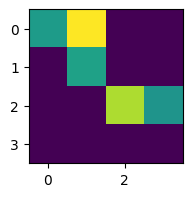

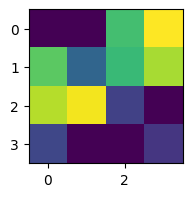

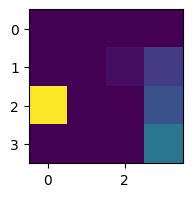

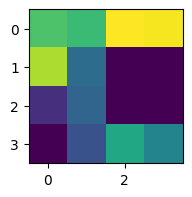

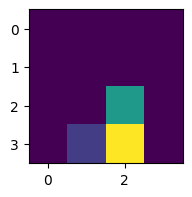

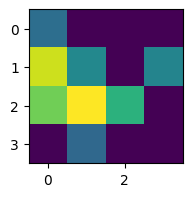

In [18]:
final_conv_out[0]
from matplotlib import pyplot as plt
for conv_kernel in final_conv_out[0].detach().numpy().reshape(6, 4, 4):
    plt.figure(figsize=(2, 2))
    plt.imshow(conv_kernel)

#plt.imshow(final_conv_out[0].detach().numpy().reshape(6, 4, 4))

In [19]:
Xtrain_mixed = final_conv_out
Xtrain_mixed = Xtrain_mixed > 0

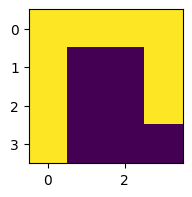

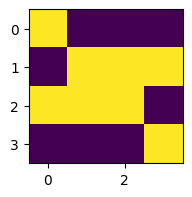

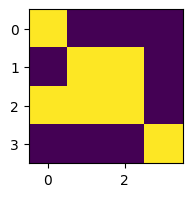

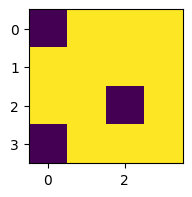

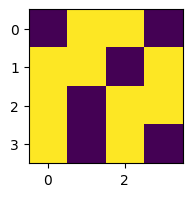

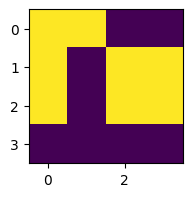

In [20]:
for conv_kernel in Xtrain_mixed[1].detach().numpy().reshape(6, 4, 4):
    plt.figure(figsize=(2, 2))
    plt.imshow(conv_kernel)

In [21]:
from TNSPC.layers.leaves import NormalLeaf, CategoricalLeaf
from TNSPC.layers.TNSPCclass import MultiLeaf

# Hyperparameters
T = 1 # Number of tracks
C = 82  # Number of channels
V = 96  # Number of input variables (e.g., pixels)
classes = 10  # Number of output classes (e.g., digits 0-9)

# Define individual leaf distributions
input_leaf = BernoulliLeaf(T, V, C)         # Gaussian for pixel inputs
output_leaf = CategoricalLeaf(T, 1, C, 10)  # Categorical for class labels


# Combine them into a MultiLeaf
multi_leaf = MultiLeaf(input_leaf, output_leaf)

print(multi_leaf[1])

mixed_model = Sequential(multi_leaf,
                     Weightsum(T, V + 1, C)) 

#model = tp.utils.model.CP_(T, V, C, multi_leaf).to(device)

print(mixed_model)

CategoricalLeaf()
Sequential(
  (0): MultiLeaf(
    (0): BernoulliLeaf()
    (1): CategoricalLeaf()
  )
  (1): Weightsum()
)


In [208]:
cp_channels(1/6, 8000, V)


14

In [220]:
concatenated = torch.cat((Xtrain_mixed.float(), Ytrain.int()[:,None]), dim =1)
concatenated.shape


torch.Size([8000, 97])

In [213]:
x = concatenated
for i, layer in enumerate(mixed_model):
    x = layer(x)
    print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")

print()

After layer 0 (MultiLeaf): torch.Size([8000, 1, 97, 82])
After layer 1 (Weightsum): torch.Size([8000])



In [150]:
accs = []
mixed_model = Sequential(multi_leaf,
                    Weightsum(T, V + 1, C)) 
mixed_model.train()
tp.utils.model.train(mixed_model, [concatenated], device = device, epochs = 10, show_progress=True)
Xtest_mixed = cnn_model_2l.return_hidden(Xtest.view(-1, 1, 28, 28))
Xtest_mixed = Xtest_mixed > 0
empty_y = torch.zeros(Xtest_mixed.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest_mixed.float(), empty_y[:,None]), dim =1)
leaves_types = ["B"] * 96 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(mixed_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]
num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)
accs.append(num_correct/frac_test)

Epoch 10, Avg P: -37.0808: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C']
tensor(0.9045)


In [151]:
Xtest_mixed = cnn_model_2l.return_hidden(Xtest.view(-1, 1, 28, 28))
Xtest_mixed = Xtest_mixed > 0
empty_y = torch.zeros(Xtest_mixed.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest_mixed.float(), empty_y[:,None]), dim =1)

In [152]:
leaves_types = ["B"] * 96 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(mixed_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C']


In [153]:
num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)

tensor(0.9045)


In [154]:
predicted_label

tensor([0., 6., 2.,  ..., 6., 9., 7.])

In [155]:
total_params = sum(p.numel() for p in pc_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 7950


In [156]:
total_params = sum(p.numel() for p in mixed_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 8774


In [32]:
cp_channels(1, 8000, pc_model[0].V)


10

In [33]:
cp_channels(1, 8000, mixed_model[0].V)


82

# Experiment (train size)

In [172]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class ff_Model(nn.Module):
    def __init__(self,  num_classes = 10):
        super(ff_Model, self).__init__()

        self.fc1 = nn.Linear(96, 76)
        self.fc2 = nn.Linear(76, num_classes)

        self.print_size = PrintSize()
    
    def forward(self, x):
      #x = nn.Flatten()(x)
    
      
      x = F.relu(self.fc1(x))
      
      x = self.fc2(x)

      return x
    




In [173]:
# Count total parameters
ff_model = ff_Model(10)
trainable_params = sum(p.numel() for p in ff_model.parameters())
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 8142


In [71]:
concatenated[0]


tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 5.])

In [72]:
# Input into Mixed PC
def get_mini_batch(start= 0, stop = 2000):
    tuples = []
    for i in range (start, stop):
        line = concatenated[i]
        tuple = (line[:-1], line[-1])
        tuples.append(tuple)

    return tuples

In [76]:
# Initialize the network, loss function, and optimizer
import torch.optim as optim

ff_model = ff_Model(10)
device = torch.device('cpu')  # use cuda or cpu
ff_model.to(device)
print(ff_model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ff_model.parameters(), lr=0.001)

# Train the model
epochs = 10
batch_10 = get_mini_batch(0, 1000)
#print(batch_10.shape)
for epoch in range(epochs):
    ff_model.train()
    running_loss = 0.0
    for images, labels in batch_10:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Convert labels to Long type
        labels = torch.tensor(labels.long())
        
        # Forward pass
        outputs = ff_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    # Validation step
    ff_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    test = get_mini_batch(1000, 2000)
    with torch.no_grad():
        for images, labels in test:
            labels = labels.long()
            images = images.float()
            outputs = ff_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.argmax(outputs)
            total += 1

            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")

    

ff_Model(
  (fc1): Linear(in_features=96, out_features=76, bias=True)
  (fc2): Linear(in_features=76, out_features=10, bias=True)
  (print_size): PrintSize()
)


C:\Users\Milosz\AppData\Local\Temp\ipykernel_6376\2498096215.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.long())


Epoch 1/10, Training Loss: 7.7652, Validation Loss: 15.3461, Validation Accuracy: 85.10%
Epoch 2/10, Training Loss: 2.7198, Validation Loss: 13.0235, Validation Accuracy: 86.90%
Epoch 3/10, Training Loss: 2.0003, Validation Loss: 13.1480, Validation Accuracy: 86.60%
Epoch 4/10, Training Loss: 1.5686, Validation Loss: 13.5017, Validation Accuracy: 86.40%
Epoch 5/10, Training Loss: 1.2337, Validation Loss: 13.9161, Validation Accuracy: 85.90%
Epoch 6/10, Training Loss: 0.9598, Validation Loss: 14.3021, Validation Accuracy: 86.60%
Epoch 7/10, Training Loss: 0.7304, Validation Loss: 15.1668, Validation Accuracy: 86.50%
Epoch 8/10, Training Loss: 0.5526, Validation Loss: 15.4248, Validation Accuracy: 87.30%
Epoch 9/10, Training Loss: 0.4003, Validation Loss: 16.0416, Validation Accuracy: 87.10%
Epoch 10/10, Training Loss: 0.2782, Validation Loss: 16.3951, Validation Accuracy: 87.50%


In [38]:
input_leaf = BernoulliLeaf(T, V, C)         # Gaussian for pixel inputs
output_leaf = CategoricalLeaf(T, 1, C, 10)  # Categorical for class labels
mixed_model_mini = Sequential(multi_leaf,
                     Weightsum(T, V + 1, C)) 

In [39]:
mixed_model_mini.train()
tp.utils.model.train(mixed_model_mini, [concatenated[:1000]], device = device, epochs = 100, show_progress=True)

Epoch 100, Avg P: -33.1360: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


In [214]:
leaves_types = ["B"] * 96 + ["C"]


imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

print(mXtest[0])

b_mXtest = tp.utils.data.batch(mXtest, 100)

print(b_mXtest[0].shape)

Ximputed = tp.utils.impute.b_impute(mixed_model_mini.train(), b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., nan])
torch.Size([100, 97])
tensor(0.9060)


# Experiment 2: missing data

### Missing data - Mixed model

In [226]:
concatenated_test_1000 = torch.clone(concatenated_test[:1000, ])

In [237]:
concatenated_test_1000[:, :64] = float("nan")

In [238]:
leaves_types = ["B"] * 96 + ["C"]


imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test_1000)

b_mXtest = tp.utils.data.batch(mXtest, 100)


Ximputed = tp.utils.impute.b_impute(mixed_model.train(), b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


num_correct = torch.sum(predicted_label == Ytest[:1000])
print(num_correct/len(Ytest[:1000]))

tensor(0.8150)


### Missing data - FFN

In [215]:
# Initialize the network, loss function, and optimizer
import torch.optim as optim

ff_model = ff_Model(10)
device = torch.device('cpu')  # use cuda or cpu
ff_model.to(device)
print(ff_model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ff_model.parameters(), lr=0.001)

# Train the model
epochs = 10
batch_10 = get_mini_batch(0, 7000)
#print(batch_10.shape)
for epoch in range(epochs):
    ff_model.train()
    running_loss = 0.0
    for images, labels in batch_10:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Convert labels to Long type
        labels = torch.tensor(labels.long())
        
        # Forward pass
        outputs = ff_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    # Validation step
    ff_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    test = get_mini_batch(7000, 8000)
    with torch.no_grad():
        for images, labels in test:
            labels = labels.long()
            images = images.float()
            outputs = ff_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.argmax(outputs)
            total += 1

            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")

    

ff_Model(
  (fc1): Linear(in_features=96, out_features=76, bias=True)
  (fc2): Linear(in_features=76, out_features=10, bias=True)
  (print_size): PrintSize()
)


C:\Users\Milosz\AppData\Local\Temp\ipykernel_6376\376980080.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.long())


Epoch 1/10, Training Loss: 22.8326, Validation Loss: 9.7032, Validation Accuracy: 89.40%
Epoch 2/10, Training Loss: 13.2437, Validation Loss: 9.2504, Validation Accuracy: 90.60%
Epoch 3/10, Training Loss: 10.9003, Validation Loss: 9.0103, Validation Accuracy: 91.20%
Epoch 4/10, Training Loss: 9.2502, Validation Loss: 9.4070, Validation Accuracy: 90.80%
Epoch 5/10, Training Loss: 7.9593, Validation Loss: 10.0089, Validation Accuracy: 90.80%
Epoch 6/10, Training Loss: 6.7399, Validation Loss: 10.4092, Validation Accuracy: 90.70%
Epoch 7/10, Training Loss: 5.7114, Validation Loss: 10.8915, Validation Accuracy: 90.50%
Epoch 8/10, Training Loss: 4.9226, Validation Loss: 11.4151, Validation Accuracy: 90.60%
Epoch 9/10, Training Loss: 4.2606, Validation Loss: 12.2488, Validation Accuracy: 91.00%
Epoch 10/10, Training Loss: 3.7290, Validation Loss: 13.7986, Validation Accuracy: 90.40%


In [224]:

# Validation step
ff_model.eval()
val_loss = 0.0
correct = 0
total = 0
accs = []
test = get_mini_batch(7000, 8000).copy()

with torch.no_grad():
    for images, labels in test:
        labels = labels.long()
        images = images.float()
        images[:64] = 0
        outputs = ff_model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        predicted = torch.argmax(outputs)
        total += 1

        correct += (predicted == labels).sum().item()

print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")
acc = correct / total
accs.append(acc)


Epoch 10/10, Training Loss: 3.7290, Validation Loss: 64.9627, Validation Accuracy: 49.10%


# Plots

### TRain size


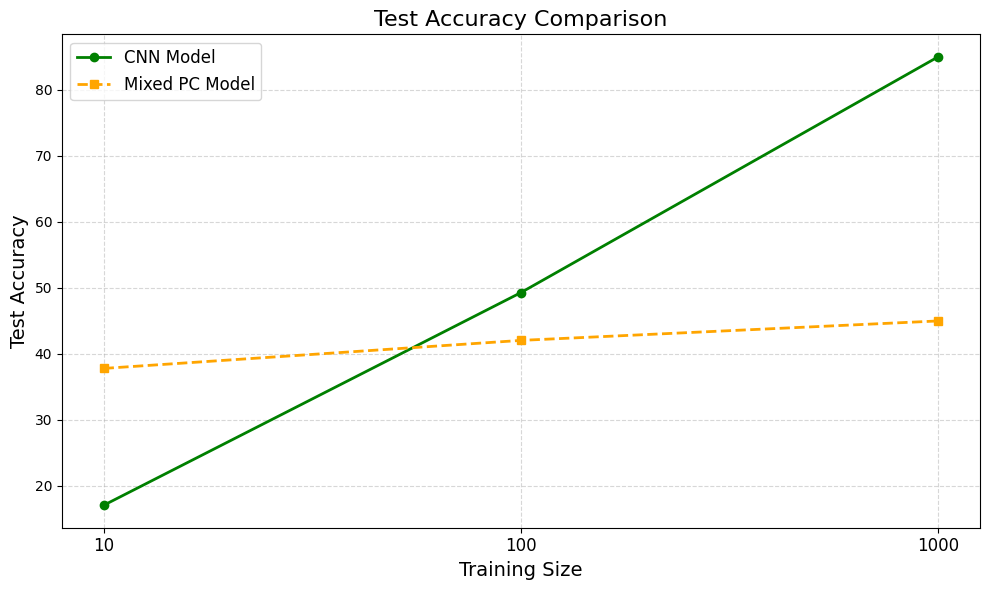

In [44]:

CNN_accs = [17, 49.25, 85]
PC_accs = [37.75, 42, 44.95]


# Example data
x_labels = ["10", "100", "1000"]  # Custom x-axis labels
test_accuracy_model1 = CNN_accs
test_accuracy_model2 = PC_accs


# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity

# Plot the lines
plt.plot(x_labels, test_accuracy_model1, label='CNN Model', marker='o', linestyle='-', c = "green", linewidth=2)
plt.plot(x_labels, test_accuracy_model2, label='Mixed PC Model', marker='s', linestyle='--', c = "orange", linewidth=2)

# Add title and labels
plt.title('Test Accuracy Comparison', fontsize=16)
plt.xlabel('Training Size', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)

# Customize x-ticks
plt.xticks(x_labels, fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5, linestyle='--')

# Add legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


### Accuracies

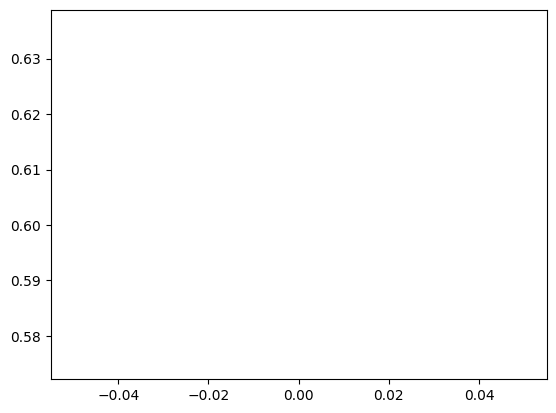

In [45]:
# Mixed Model accs 
#accs.tolist()
basline_list = list(acc.item() for acc in accs_baseline)
pc_list =  list(acc.item() for acc in accs)
plt.figure()
plt.plot(basline_list)

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

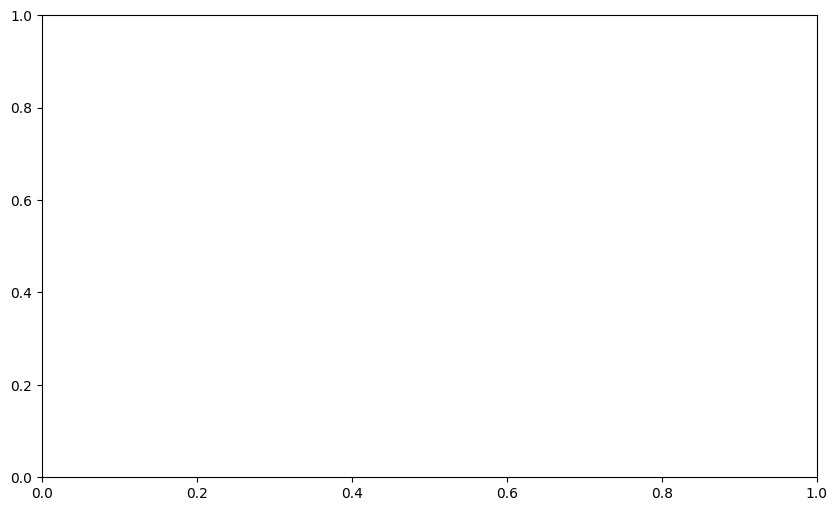

In [46]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 10 epochs
test_accuracy_model1 = basline_list
# final acc: 58.55
test_accuracy_model2 = pc_list
# final acc: 93.5
test_accuracy_model3 = accs_cnn
# final acc: 93.5


# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity

# Plot the lines
plt.plot(epochs, test_accuracy_model1, label='Baseline PC Model', linestyle='-', linewidth=2)
plt.plot(epochs, test_accuracy_model2, label='Mixed PC Model', linestyle='--', linewidth=2)
plt.plot(epochs, test_accuracy_model3, label='CNN Model', linestyle='-.', linewidth=2)

# Add title and labels
plt.title('Test Accuracy Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)

# Add grid for better readability
plt.grid(alpha=0.5, linestyle='--')

# Add legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


In [526]:
print(f"final accuracies: baseline: {round(basline_list[-1], 2)}, mixed model: {round(pc_list[-1], 2)}, CNN: {round(accs_cnn[-1], 2)}")

final accuracies: baseline: 0.58, mixed model: 0.88, CNN: 0.94


### Plot missing data accuracies

In [ ]:
# FFN missing accs
fnn_accs = [88.90, 69.00, 72.60, 49.10]
mm_accs = [0.8880, 0.8810, 0.8830, 0.8150]

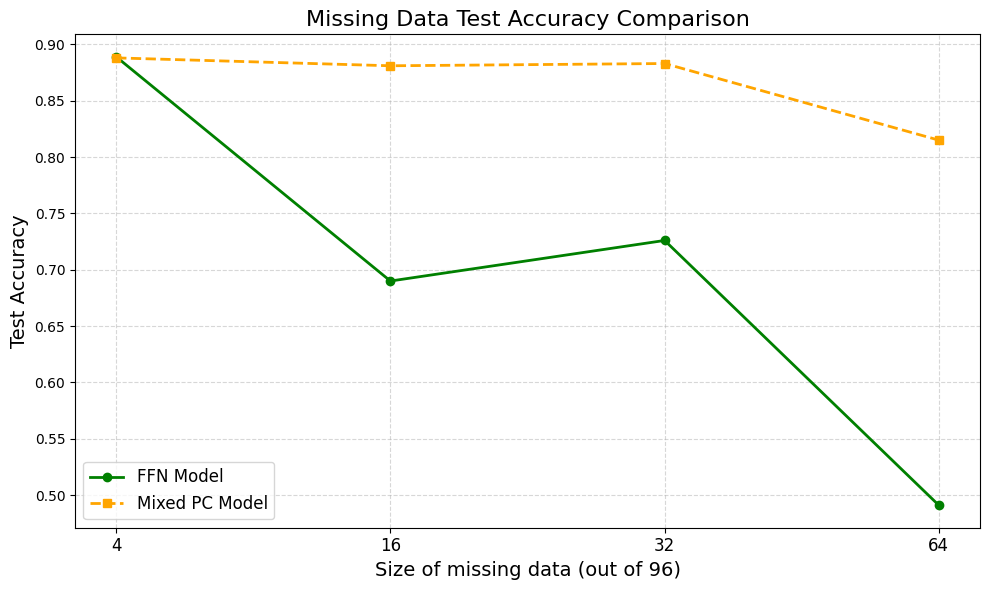

In [245]:
fnn_accs = list(a*0.01 for a in [88.90, 69.00, 72.60, 49.10])
mm_accs = [0.8880, 0.8810, 0.8830, 0.8150]


# Example data
x_labels = list(str(a) for a in [4, 16, 32, 64])  # Custom x-axis labels
test_accuracy_model1 = fnn_accs
test_accuracy_model2 = mm_accs


# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity

# Plot the lines
plt.plot(x_labels, test_accuracy_model1, label='FFN Model', marker='o', linestyle='-', c = "green", linewidth=2)
plt.plot(x_labels, test_accuracy_model2, label='Mixed PC Model', marker='s', linestyle='--', c = "orange", linewidth=2)

# Add title and labels
plt.title('Missing Data Test Accuracy Comparison', fontsize=16)
plt.xlabel('Size of missing data (out of 96)', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)

# Customize x-ticks
plt.xticks(x_labels, fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5, linestyle='--')

# Add legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
